# Video-Aula

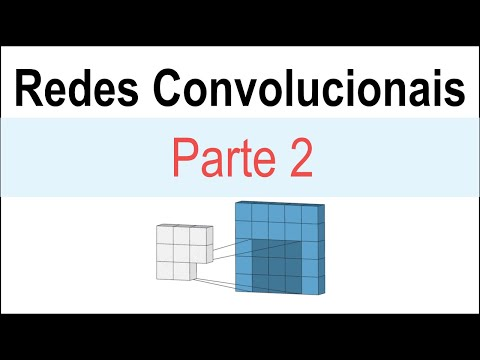

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('xRC95W55Y8g')

## Obtenção dos Dados

Este código baixa os arquivos do [_dataset_ MNIST](https://en.wikipedia.org/wiki/MNIST_database) a partir do [site](http://yann.lecun.com/exdb/mnist/) do [Prof. Yann LeCun](https://en.wikipedia.org/wiki/Yann_LeCun).

In [ ]:
# Imagens de treinamento
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz -O train-images-idx3-ubyte.gz
# Rótulos (classes)
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz -O train-labels-idx1-ubyte.gz
# Imagens de validação
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz -O t10k-images-idx3-ubyte.gz
# Rótulos de validação (classes)
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz -O t10k-labels-idx1-ubyte.gz

--2020-12-17 06:51:39--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 172.67.171.76, 104.28.6.204, 104.28.7.204, ...
Connecting to yann.lecun.com (yann.lecun.com)|172.67.171.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  54.6MB/s    in 0.2s    

2020-12-17 06:51:39 (54.6 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2020-12-17 06:51:39--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 172.67.171.76, 104.28.6.204, 104.28.7.204, ...
Connecting to yann.lecun.com (yann.lecun.com)|172.67.171.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

train-labels-idx1-u 100%[===================>]  28.20K  --.-

Abaixo extraímos os arquivos comprimidos. 

In [ ]:
# Extrai os arquivos treinamento
!gunzip -f *.gz

## Importação de Bibliotecas


In [ ]:
# Importa as bibliotecas que usaremos

import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim

import numpy as np
from matplotlib import pyplot as plt

# Ajusta os parâmetro de precisão para
# as variáveis que serão impressas na tela

torch.set_printoptions(precision=2, sci_mode=False)
np.set_printoptions(precision=2)

## Leitura dos Dados

Abaixo definimos as funções auxiliares para leitura do arquivo de imagens

In [ ]:
from struct import unpack

def read_imgs(img_filename):
  ''' Esta função lê o arquivo de imagens
      da base de dados MNIST
  '''

  # Abre o arquivo
  img_file = open(img_filename,'rb')

  # Lê o cabeçalho do arquivo
  magic = unpack('>i', img_file.read(4))[0]
  total = unpack('>i', img_file.read(4))[0]
  height = unpack('>i', img_file.read(4))[0]
  width = unpack('>i', img_file.read(4))[0]

  # Verifica se o arquivo passa no teste
  # básico (este número deve ser sempre 2051)
  if magic != 2051:
    print('Erro, este arquivo não parece ser um arquivo de imagens MNIST')

  # Aqui criamos a array do NumPy que armazenará
  # as imagens
  imgs = np.zeros((total,height,width), dtype=float)

  # Nesse laço vamos lendo cada pixel e preenchendo
  # no array
  for k in range(total): # Cada amostra k
    for i in range(height): # Cada linha i
      for j in range(width): # Cada coluna j
        imgs[k,i,j] = ord(img_file.read(1)) # Lemos 1 byte
  
  # Retornamos o array preenchido
  # e já normalizado para valores
  # entre zero e um
  return imgs / 255.0

De forma semelhante ao realizado acima, aqui abaixo definimos as funções auxiliares para leitura do arquivo de rótulos.

In [ ]:
def read_labels(labels_filename):
  ''' Esta função lê o arquivo de rótulos
      da base de dados MNIST
  '''

  # Abre o arquivo
  labels_file = open(labels_filename,'rb')

  # Lê o cabeçalho do arquivo
  magic = unpack('>i', labels_file.read(4))[0]
  total = unpack('>i', labels_file.read(4))[0]

  # Verifica se o arquivo passa no teste
  # básico (este número deve ser sempre 2051)
  if magic != 2049:
    print('Erro, este arquivo não parece ser um arquivo de imagens MNIST')

  # Aqui criamos a array do NumPy que armazenará
  # as imagens
  labels = np.zeros((total), dtype=int)

  # Nesse laço vamos lendo cada label e preenchendo
  # no array
  for k in range(total): # Cada amostra k
    labels[k] = ord(labels_file.read(1)) # Lemos 1 byte
  
  # Retornamos o array preenchido
  return labels

Nas linhas abaixo chamamos as função de leitura para carregar as imagens e os respectivos rótulos

In [ ]:
# Dados de treinamento

Xt = read_imgs('train-images-idx3-ubyte')
Yt = read_labels('train-labels-idx1-ubyte')

# Dados de validação
Xv = read_imgs('t10k-images-idx3-ubyte')
Yv = read_labels('t10k-labels-idx1-ubyte')

## Embaralhamento das Amostras

In [ ]:
def shuffle_pair(x, y):
  idxs = list(range(len(y)))
  np.random.shuffle(idxs)
  return x[idxs], y[idxs]

In [ ]:
Xt, Yt = shuffle_pair(Xt, Yt)
Xv, Yv = shuffle_pair(Xv, Yv)

## Conversão para PyTorch

In [ ]:
Xt = torch.tensor(Xt)
Yt = torch.tensor(Yt, dtype=torch.long)
Xv = torch.tensor(Xv)
Yv = torch.tensor(Yv, dtype=torch.long)

In [ ]:
Xt = Xt.unsqueeze(1)
Xv = Xv.unsqueeze(1)

# Rede Neural

O código abaixo definimos uma rede neural convolucional.

In [ ]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 5, kernel_size=5)  #  1x28x28 => 5x24x24
    self.pool1 = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(5, 8, kernel_size=3)  #  5x12x12 => 10x10x10
    self.drp1 = nn.Dropout2d(0.25)               #   8x5x5 => 
    self.pool2 = nn.MaxPool2d(2, 2)
    self.lin1 = nn.Linear(200, 10)               #     200 => 10
    
  def forward(self, x):
    x = self.conv1(x)
    x = torch.relu(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.drp1(x)
    x = torch.relu(x)
    x = self.pool2(x)
    x = x.view(-1, 200)
    x = self.lin1(x)
    return x


In [ ]:
cnn = ConvNet()
print(cnn)

ConvNet(
  (conv1): Conv2d(1, 5, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(5, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drp1): Dropout2d(p=0.25, inplace=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lin1): Linear(in_features=200, out_features=10, bias=True)
)


# Treinamento

Esta rede neural será treinada em $1001$ épocas, e isso levará em torno de $20$ minutos (aproximadamente $2$ minutos por época)

In [ ]:
# Aqui criamos o otimizador e a função
# de perda

opt = optim.Adam(cnn.parameters(), lr=0.0001)
loss = nn.CrossEntropyLoss()

In [ ]:
# Movemos tudo para a GPU
# (essa parte é opcional)

gpu = torch.device("cuda:0")
cnn = cnn.to(gpu)
Xt = Xt.to(gpu, dtype=torch.float)
Yt = Yt.to(gpu, dtype=torch.long)
Xv = Xv.to(gpu, dtype=torch.float)
Yv = Yv.to(gpu, dtype=torch.long)

In [ ]:
# Essa função serve para verificarmos
# a acurácia dos resultados, seja
# nos pares de treinamento, seja
# nos pares de validação.

def evaluate(x, y_hat):
  y = cnn(x).argmax(dim=1)
  return 100*float((y == y_hat).sum()) / len(y)

In [ ]:
# Treinamento da rede neural
# Treinamento por 10 épocas
# usando lotes de 16 amostras
# (pode repetir essa célula várias
#  vezes para tentar aumentar a
#  acurácia)

for j in range(10):
  for i in range(0,len(Yt),16):
    x = Xt[i:i+16,:,:,:]
    y_hat = Yt[i:i+16]
    opt.zero_grad()
    y = cnn(x)
    e = loss(y, y_hat)
    e.backward()
    opt.step()
  print(float(e), evaluate(Xt, Yt))

# Avaliação dos Resultados

In [ ]:
# Essa linha de código coloca a
# rede neural no modo de avaliação
# (tira do modo de treinamento).
# Dessa forma o dropout é desativado

cnn.eval()

ConvNet(
  (conv1): Conv2d(1, 5, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(5, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drp1): Dropout2d(p=0.25, inplace=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lin1): Linear(in_features=200, out_features=10, bias=True)
)

Abaixo mostramos, finalmente, a acurácia nos dados de validação. O valor pode até superar a acurácia do treinamento, já que aqui dropout está desabilitado.

In [ ]:
print('Acurácia nos dados de validação:', evaluate(Xv, Yv))

Acurácia nos dados de validação: 97.58


No código abaixo mostramos alguns exemplos de saída calculada pela rede neural e respectiva saída desejada e imagem correspondente.

y = 1 y_hat = 1


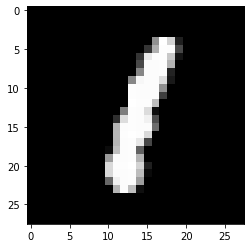

y = 7 y_hat = 7


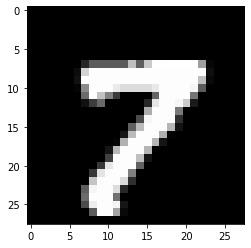

y = 7 y_hat = 4


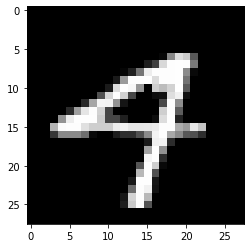

y = 8 y_hat = 8


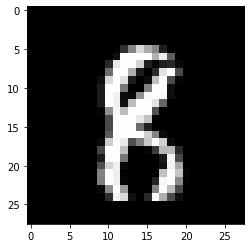

y = 2 y_hat = 2


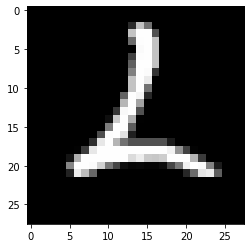

In [ ]:
for _ in range(5):
  idx = np.random.randint(0, len(Yv))
  x = Xv[idx,0,:,:].cpu()
  y = int(cnn(Xv[idx,:,:,:].unsqueeze(1)).argmax(dim=1))
  print('y =', y, 'y_hat =', int(Yv[idx]))
  plt.imshow(x, cmap='gray')
  plt.show()

A linha de código abaixo coloca a rede neural novamente em modo treinamento.

In [ ]:
cnn.train()

ConvNet(
  (conv1): Conv2d(1, 5, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(5, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drp1): Dropout2d(p=0.25, inplace=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lin1): Linear(in_features=200, out_features=10, bias=True)
)